In [1]:
# Load the wine data from chapter 4, and create a new model with the appropriate number of input parameters
import csv
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import OrderedDict

In [2]:
wine_path="./winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [3]:
col_list = next(csv.reader(open(wine_path))) #next item from the iterator
num_row = wineq_numpy.shape[0]
num_col = wineq_numpy.shape[1]
attrs = torch.tensor(np.array(wineq_numpy[:,0:11]))
ans = torch.tensor(np.array(wineq_numpy[:,11]))
attrs, ans

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 tensor([6., 6., 6.,  ..., 6., 7., 6.]))

In [4]:
quality = {0:0,1:0,2:0, 3:0, 4:0, 5:0, 6:0,7:0,8:0,9:0,10:0}
for a in ans:
    quality[a.item()]+=1
quality

{0: 0,
 1: 0,
 2: 0,
 3: 20,
 4: 163,
 5: 1457,
 6: 2198,
 7: 880,
 8: 175,
 9: 5,
 10: 0}

In [5]:
def shuffle_and_devide_set(t_u: torch, t_c:torch, ratio):
    n_samples = t_u.shape[0]
    n_val = int(ratio*n_samples)

    shuffled_indices = torch.randperm(n_samples)

    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    train_indices, val_indices
    train_t_u = t_u[train_indices]
    train_t_c = t_c [train_indices]

    val_t_u = t_u[val_indices]
    val_t_c = t_c [val_indices]

    return train_t_u, train_t_c, val_t_u, val_t_c

In [6]:
col_norm1 = [True,False,False,True,False,False,False,True,True,False,True]
col_norm2 = [False,False,False,False,False,True,True,False,False,False,False]
attrs_n = attrs.clone()
attrs_n[:,col_norm1] *= 0.1
attrs_n[:,col_norm2] *= 0.01
ans_n = ans*0.1
attr_t, ans_t, attr_v, ans_v = shuffle_and_devide_set(attrs_n, ans_n, 0.2)
ans_t = ans_t.unsqueeze(1);
ans_v = ans_v.unsqueeze(1);

print(attr_t.shape, attr_v.shape)
print(ans_t.shape, ans_v.shape)
print(attrs.mean(dim=0))
print( attrs_n.mean(dim=0))


torch.Size([3919, 11]) torch.Size([979, 11])
torch.Size([3919, 1]) torch.Size([979, 1])
tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])
tensor([0.6855, 0.2782, 0.3342, 0.6391, 0.0458, 0.3531, 1.3836, 0.0994, 0.3188,
        0.4898, 1.0514])


In [7]:
def compare_out_ans(output:torch, ans:torch) :
    r_out = torch.round(output.squeeze()*10)
    ans = ans.squeeze()*10
    total=0
    right=0
    length = output.shape[0]
    for i in range(0,length):
        total+=1
        if(r_out[i] == ans[i]):
            right+=1
    return right, total
        


In [8]:
def training_loop(n_epochs:int, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train=loss_fn(t_p_train, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch <=3 or epoch % 500 == 0:
            right, total = compare_out_ans(t_p_val, t_c_val) 
            print(f"Epoch {epoch:5d}, Train Loss {loss_train.item():.4f}, val loss {loss_val.item():.4f}",
            f"    score: {right} / {total} = {right/total*100:.2f}%")

In [12]:
model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11,11)),
    ('hidden_activation', nn.Tanh()),
    ('hidden_linear', nn.Linear(11,6)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(6,1))
       
]))
attr_t = attr_t.clone().detach().requires_grad_(True)
attr_v = attr_v.clone().detach().requires_grad_(True)
ans_t =  ans_t.clone().detach().requires_grad_(True)
ans_v =  ans_v.clone().detach().requires_grad_(True)

optimizer = optim.Adam(model.parameters(), lr =1e-2)
loss_fn = nn.MSELoss() 
training_loop(
    5000, 
    optimizer, 
    model, 
    loss_fn, 
    attr_t, 
    attr_v,
    ans_t, 
    ans_v
)



Epoch     1, Train Loss 0.6393, val loss 0.6393     score: 0 / 979 = 0.00%
Epoch     2, Train Loss 0.4976, val loss 0.4982     score: 0 / 979 = 0.00%
Epoch     3, Train Loss 0.3755, val loss 0.3766     score: 0 / 979 = 0.00%
Epoch   500, Train Loss 0.0058, val loss 0.0061     score: 508 / 979 = 51.89%
Epoch  1000, Train Loss 0.0056, val loss 0.0057     score: 514 / 979 = 52.50%
Epoch  1500, Train Loss 0.0055, val loss 0.0057     score: 512 / 979 = 52.30%
Epoch  2000, Train Loss 0.0054, val loss 0.0055     score: 525 / 979 = 53.63%
Epoch  2500, Train Loss 0.0054, val loss 0.0055     score: 526 / 979 = 53.73%
Epoch  3000, Train Loss 0.0053, val loss 0.0054     score: 517 / 979 = 52.81%
Epoch  3500, Train Loss 0.0053, val loss 0.0054     score: 517 / 979 = 52.81%
Epoch  4000, Train Loss 0.0053, val loss 0.0054     score: 520 / 979 = 53.12%
Epoch  4500, Train Loss 0.0052, val loss 0.0053     score: 521 / 979 = 53.22%
Epoch  5000, Train Loss 0.0052, val loss 0.0054     score: 523 / 979 = 53

Text(0, 0.5, 'out')

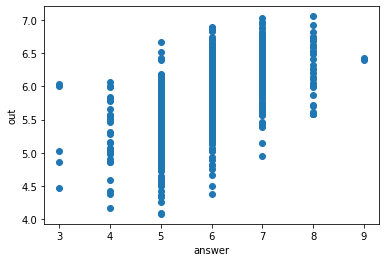

In [13]:
out = (model(attr_v)*10).detach().numpy()

fig1= plt.plot(ans_v.detach().numpy()*10,out, 'o', )
plt.xlabel("answer")
plt.ylabel("out")